In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Transported
True     4378
False    4315
Name: count, dtype: int64


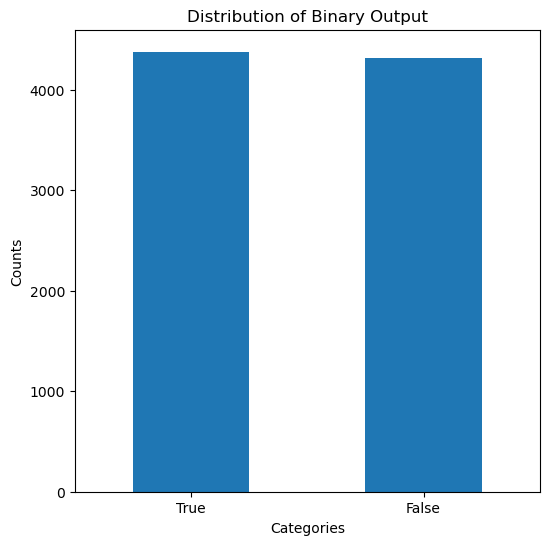

In [3]:
import matplotlib.pyplot as plt

# Calculate counts of each category
counts = train_data['Transported'].value_counts()
print(counts)

# Plotting
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')
plt.title('Distribution of Binary Output')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=0)  # Rotate x-labels if needed
plt.show()

In [4]:
train_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [5]:
nulls = train_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

HomePlanet 201
CryoSleep 217
Cabin 199
Destination 182
Age 179
VIP 203
RoomService 181
FoodCourt 183
ShoppingMall 208
Spa 183
VRDeck 188
Name 200


In [6]:
nulls = test_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

HomePlanet 87
CryoSleep 93
Cabin 100
Destination 92
Age 91
VIP 93
RoomService 82
FoodCourt 106
ShoppingMall 98
Spa 101
VRDeck 80
Name 94


In [7]:
def fill_planets_groups(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    tem=df[['Group','HomePlanet']].groupby(['Group'])['HomePlanet'].apply(lambda x: x.mode().iloc[0] if len(x.dropna()) > 0 else None).reset_index()
    df = pd.merge(df, tem, on='Group', how='left', suffixes=('', '_right'))
    df['HomePlanet']=np.where(df['HomePlanet'].isnull(),df['HomePlanet_right'],df['HomePlanet'])
    df.drop(columns=['HomePlanet_right'], inplace=True)
    return df
def fill_planets_surnames(df):
    df[['First_name','Surname']] = df['Name'].str.split(' ', expand=True)
    tem=df[['Surname','HomePlanet']].groupby(['Surname'])['HomePlanet'].apply(lambda x: x.mode().iloc[0] if len(x.dropna()) > 0 else None).reset_index()
    df = pd.merge(df, tem, on='Surname', how='left', suffixes=('', '_right'))
    df['HomePlanet']=np.where(df['HomePlanet'].isnull(),df['HomePlanet_right'],df['HomePlanet'])
    df.drop(columns=['HomePlanet_right'], inplace=True)
    return df
def fill_missing_merge(train,test):
    train_id=train['PassengerId'].values
    test_id=test['PassengerId'].values
    removed_column = train['Transported']
    train.drop(columns=['Transported'], inplace=True)
    df=pd.concat([train, test],ignore_index=True)
    df.to_csv('data_merge_pre.csv',index=False)
    df=fill_planets_groups(df)
    df=fill_planets_surnames(df)
    train=df[df['PassengerId'].isin(train_id)]
    test=df[df['PassengerId'].isin(test_id)]
    train['Transported']=removed_column
    return train,test
def split_cabin(df,target_col=None):
    if target_col:
        removed_column = df[target_col]
        df.drop(columns=[target_col], inplace=True)
        df[['deck','num','side']]=df['Cabin'].str.split('/',expand=True)
        df[target_col]=removed_column
    else:
        df[['deck','num','side']]=df['Cabin'].str.split('/',expand=True)
    return df
def fill_planets_deck(df,target_col=None):
    df=split_cabin(df,target_col)
    df.loc[(df['HomePlanet'].isna()) & (df['deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet']='Europa'
    df.loc[(df['HomePlanet'].isna()) & (df['deck']=='G'), 'HomePlanet']='Earth'
    df.loc[(df['HomePlanet'].isna()) & ~(df['deck']=='D'), 'HomePlanet']='Earth'
    df.loc[(df['HomePlanet'].isna()) & (df['deck']=='D'), 'HomePlanet']='Mars'
    return df
def fill_expense_cryo_sleep(df):
    col_to_fill=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
    df['expenses'] = df[col_to_fill].sum(axis=1,skipna=False)
    df['expenses_w_o_na'] = df[col_to_fill].sum(axis=1,skipna=True)
    df['CryoSleep']=np.where(df['CryoSleep'].isnull()&((df['expenses']>0)|(df['expenses'].isnull()&(df['expenses_w_o_na']>0))),False,df['CryoSleep'])
    #df['CryoSleep']=np.where(df['CryoSleep'].isnull()&(df['expenses']==0),True,df['CryoSleep'])
    #df['CryoSleep']=np.where(df['CryoSleep'].isnull()&(df['expenses']==0),True,np.where(df['CryoSleep'].isnull()&((df['expenses']>0)|(df['expenses'].isnull()&(df['expenses_w_o_na']>0))),False,df['CryoSleep']))
    for col in col_to_fill:
        df[col]=np.where(df[col].isnull()&((df['CryoSleep']==True)|(df['Age'] < 13)), 0, df[col])
    #df.drop(columns=['expenses','expenses_w_o_na'], inplace=True)
    return df
def fill_missing_vip(df):
    df['VIP']=np.where(df['VIP'].isnull()&((df['Age']<18)|(df['HomePlanet']=='Earth')),False,df['VIP'])
    return df

In [8]:
train_data,test_data=fill_missing_merge(train_data,test_data)
train_data=fill_planets_deck(train_data,'Transported')
train_data=fill_expense_cryo_sleep(train_data)
train_data=fill_missing_vip(train_data)
test_data=fill_planets_deck(test_data)
test_data=fill_expense_cryo_sleep(test_data)
test_data=fill_missing_vip(test_data)
train_data.to_csv('new_train.csv',index=False)
test_data.to_csv('new_test.csv',index=False)

C:\Users\Sajin.LAPTOP-RE0DL8PH\AppData\Local\Temp\ipykernel_7536\2780478704.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Transported']=removed_column


In [9]:
nulls = train_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

CryoSleep 98
Cabin 199
Destination 182
Age 179
VIP 74
RoomService 107
FoodCourt 106
ShoppingMall 103
Spa 114
VRDeck 107
Name 200
First_name 200
Surname 200
deck 199
num 199
side 199
expenses 908


In [10]:
nulls = test_data.isnull().sum().to_frame()
for index, row in nulls.iterrows():
    if row[0] > 0:
        print(index, row[0])
    else:
        continue

CryoSleep 38
Cabin 100
Destination 92
Age 91
VIP 49
RoomService 55
FoodCourt 65
ShoppingMall 60
Spa 52
VRDeck 43
Name 94
First_name 94
Surname 94
deck 100
num 100
side 100
expenses 455
